# 💬 Task 2: Sentiment and Thematic Analysis

---

## 1. Introduction

In this section, we quantify review sentiment and identify themes to uncover satisfaction drivers and pain points for Ethiopian banking apps. We use multiple sentiment analysis methods for comparison.

---

## 2. Sentiment Analysis with TextBlob

We first use TextBlob, a simple rule-based sentiment analyzer, to classify reviews as Positive, Negative, or Neutral and compute polarity scores.

In [7]:
import pandas as pd
from textblob import TextBlob

# Load cleaned reviews
df = pd.read_csv('../data/bank_reviews_clean.csv')

# --- Sentiment Analysis using TextBlob ---
def get_textblob_sentiment(text):
    blob = TextBlob(str(text))
    polarity = blob.sentiment.polarity
    if polarity > 0.1:
        return 'POSITIVE'
    elif polarity < -0.1:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

df['textblob_sentiment'] = df['review'].apply(get_textblob_sentiment)
df['textblob_polarity'] = df['review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# --- Aggregate by bank and rating ---
sentiment_agg = df.groupby(['bank', 'rating'])['textblob_polarity'].mean().reset_index()
print(sentiment_agg.head())

# --- (Optional) Save results ---
df.to_csv('../data/sentiment_textblob.csv', index=False)

  bank  rating  textblob_polarity
0  BOA       1          -0.121152
1  BOA       2          -0.021473
2  BOA       3           0.114022
3  BOA       4           0.348488
4  BOA       5           0.431643


---

## 3. Sentiment Analysis with DistilBERT

We now use a transformer-based model, `distilbert-base-uncased-finetuned-sst-2-english`, to classify each review as Positive or Negative and compute sentiment scores. This approach leverages deep learning for more nuanced sentiment detection.

In [8]:
from transformers import pipeline

# Load sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def get_bert_sentiment(text):
    result = sentiment_pipeline(str(text)[:512])[0]
    return result['label']

def get_bert_score(text):
    result = sentiment_pipeline(str(text)[:512])[0]
    return result['score']

df['bert_sentiment'] = df['review'].apply(get_bert_sentiment)
df['bert_score'] = df['review'].apply(get_bert_score)

# --- Aggregate by bank and rating ---
bert_agg = df.groupby(['bank', 'rating'])['bert_score'].mean().reset_index()
print(bert_agg.head())

# --- (Optional) Save results ---
df.to_csv('../data/sentiment_bert.csv', index=False)

Device set to use cpu


  bank  rating  bert_score
0  BOA       1    0.975631
1  BOA       2    0.957897
2  BOA       3    0.967069
3  BOA       4    0.973705
4  BOA       5    0.961710


---

## 4. Sentiment Analysis with VADER (Optional)

VADER is a lexicon and rule-based sentiment analysis tool specifically designed for social media text. We use it here for additional comparison.

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
df['vader_compound'] = df['review'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

# --- Aggregate by bank and rating ---
vader_agg = df.groupby(['bank', 'rating'])['vader_compound'].mean().reset_index()
print(vader_agg.head())

# --- (Optional) Save results ---
df.to_csv('../data/sentiment_vader.csv', index=False)

  bank  rating  vader_compound
0  BOA       1       -0.176971
1  BOA       2       -0.042988
2  BOA       3        0.162709
3  BOA       4        0.291150
4  BOA       5        0.374869


---

## 5. Comparison and Next Steps

With sentiment scores from TextBlob, DistilBERT, and VADER, you can now compare the results and choose the most appropriate method for further thematic analysis and visualization.

---

## 6. Thematic Analysis

A theme refers to a recurring concept or topic within user reviews. For this challenge, themes help summarize user feedback into actionable categories for the banks.

We will:
- Extract significant keywords and n-grams using TF-IDF.
- Optionally, use topic modeling for deeper insights.
- Manually group related keywords into 3–5 overarching themes per bank.
- Document the grouping logic.

---

In [10]:
# Keyword Extraction using TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

# Extract keywords and bigrams
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=30, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['review'].astype(str))
keywords = tfidf.get_feature_names_out()

print("Top keywords and bigrams:", keywords)

Top keywords and bigrams: ['account' 'app' 'application' 'bank' 'banking' 'best' 'best app' 'cbe'
 'doesn' 'easy' 'easy use' 'fast' 'fix' 'good' 'good app' 'great' 'like'
 'mobile' 'mobile banking' 'money' 'nice' 'nice app' 'service' 'time'
 'transaction' 'transfer' 'update' 'use' 'work' 'working']


---

### Manual/Rule-based Clustering

We now group the extracted keywords and bigrams into broader themes. Example themes:
- Account Access Issues
- Transaction Performance
- User Interface & Experience
- Customer Support
- Feature Requests

Below is a sample rule-based approach for assigning themes.
---

In [11]:
# Rule-based theme assignment (example logic)
def assign_theme(text):
    text = text.lower()
    if any(word in text for word in ['login', 'access', 'password', 'account locked']):
        return 'Account Access Issues'
    elif any(word in text for word in ['transfer', 'transaction', 'delay', 'pending']):
        return 'Transaction Performance'
    elif any(word in text for word in ['interface', 'design', 'easy', 'navigation', 'ui']):
        return 'User Interface & Experience'
    elif any(word in text for word in ['support', 'help', 'customer service', 'response']):
        return 'Customer Support'
    elif any(word in text for word in ['feature', 'add', 'request', 'option']):
        return 'Feature Requests'
    else:
        return 'Other'

df['theme'] = df['review'].apply(assign_theme)
df[['review', 'theme']].head()

,review,theme
0,20 years,Other
1,A great app. It's like carrying a bank in your...,Other
2,More than garrantty bank EBC.,Other
3,really am happy to this app it is Siple to use...,Other
4,I liked this app. But the User interface is ve...,User Interface & Experience


---

### Theme Distribution

We can now visualize the frequency of each theme per bank to identify the most common user concerns.

---

---

## 7. Preprocessing and Keyword Extraction

We preprocess the reviews using tokenization, stop-word removal, and optional lemmatization. Then, we extract keywords using spaCy or TF-IDF. The results are saved as a CSV file with review text, sentiment, score, and identified theme(s).

---

In [13]:
# Preprocessing: Tokenization, stop-word removal, lemmatization (optional)
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    doc = nlp(str(text))
    tokens = [
        token.lemma_.lower() for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]
    return " ".join(tokens)

df['review_clean'] = df['review'].apply(preprocess)
df[['review', 'review_clean']].head()

,review,review_clean
0,20 years,year
1,A great app. It's like carrying a bank in your...,great app like carry bank pocket
2,More than garrantty bank EBC.,garrantty bank ebc
3,really am happy to this app it is Siple to use...,happy app siple use
4,I liked this app. But the User interface is ve...,like app user interface basic attractive


In [14]:
# Keyword Extraction using TF-IDF (on cleaned reviews)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=30)
tfidf_matrix = tfidf.fit_transform(df['review_clean'])
keywords = tfidf.get_feature_names_out()
print("Top keywords and bigrams:", keywords)

Top keywords and bigrams: ['account' 'app' 'application' 'bad' 'bank' 'banking' 'cbe' 'easy'
 'easy use' 'fast' 'fix' 'good' 'good app' 'great' 'like' 'mobile'
 'mobile banking' 'money' 'need' 'nice' 'nice app' 'service' 'thank'
 'time' 'transaction' 'transfer' 'update' 'use' 'well' 'work']


---

## 8. Theme Clustering

We cluster the extracted keywords and reviews into 3–5 main themes per bank (e.g., UI, reliability, support, transaction issues, feature requests) using rule-based logic.

---

In [15]:
# Example rule-based theme assignment (customize as needed)
def assign_theme(text):
    text = text.lower()
    if any(word in text for word in ['login', 'access', 'password', 'account locked']):
        return 'Account Access Issues'
    elif any(word in text for word in ['transfer', 'transaction', 'delay', 'pending', 'fail']):
        return 'Transaction Performance'
    elif any(word in text for word in ['interface', 'design', 'easy', 'navigation', 'ui']):
        return 'User Interface & Experience'
    elif any(word in text for word in ['support', 'help', 'customer service', 'response']):
        return 'Customer Support'
    elif any(word in text for word in ['feature', 'add', 'request', 'option']):
        return 'Feature Requests'
    else:
        return 'Other'

df['theme'] = df['review_clean'].apply(assign_theme)
df[['review', 'theme']].head()

,review,theme
0,20 years,Other
1,A great app. It's like carrying a bank in your...,Other
2,More than garrantty bank EBC.,Other
3,really am happy to this app it is Siple to use...,Other
4,I liked this app. But the User interface is ve...,User Interface & Experience


In [16]:
# Save processed results as CSV
df[['review', 'review_clean', 'textblob_sentiment', 'textblob_polarity', 'bert_sentiment', 'bert_score', 'vader_compound', 'theme']].to_csv(
    '../data/review_sentiment_theme.csv', index=False
)
print("Saved processed reviews with sentiment and theme labels.")

Saved processed reviews with sentiment and theme labels.


---

## 9. Theme Distribution Visualization

We visualize the frequency of each theme per bank to identify the most common user concerns.

---

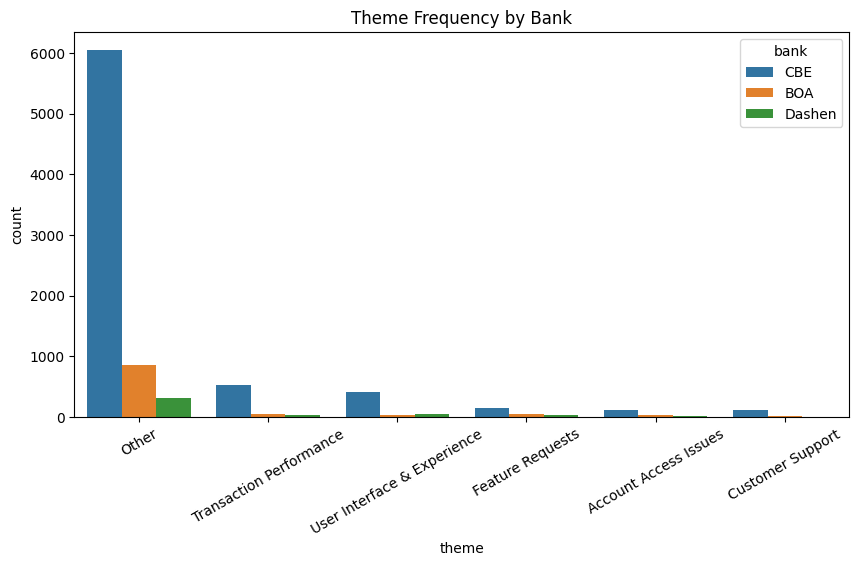

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(data=df, x='theme', hue='bank', order=df['theme'].value_counts().index)
plt.title('Theme Frequency by Bank')
plt.xticks(rotation=30)
plt.show()

---

## 10. Store Cleaned Data in Oracle

In this step, we design and implement a relational database in Oracle to persistently store the cleaned and processed review data. This simulates real-world enterprise data engineering workflows, especially within banks where Oracle is commonly used.

### Tasks

- Create a database (or schema) named `bank_reviews`
- Define schema:
  - **Banks Table:** Stores information about the banks
  - **Reviews Table:** Stores the scraped and processed review data
- Insert cleaned review data using Python

---

In [11]:
import sys
import os

# Add the parent directory of 'src' to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.db import create_schema

# Replace with your Oracle XE credentials and DSN
user = "PDADMIN"
password = "dohardthings"
dsn = "localhost/XEPDB1"

create_schema(user, password, dsn)

OperationalError: DPY-6005: cannot connect to database (CONNECTION_ID=yXWic2N5X6DvUxkKrLZdXA==).
[Errno 111] Connection refused